# My COVID-19 data experiments
These are my attempts at visualizing and analysing CoVID-19 data
put out on the github datasets curated from the JHU data.
*Do not take anything here too seriously*. 
I am just a physicist trying to calm my mind and maybe provide some
useful information to people during lock-down by doing some simple 
data anlysing/modelling. If you want *real* research go to the
*real* epidemiologists at some university/institute *not* to 
the random guy on the internet (i.e. me).

In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Use logarithmic scales?
LOGY=True

# Select countries of general interest
selcnt = []
selcnt += ['China', 'Korea, South']
selcnt += ['United Kingdom', 'US']
selcnt += ['Sweden','Germany','Norway']
selcnt += ['Italy', 'Spain']
selcnt += ['Russia',]

# Countries for plwiki plots
plwiki = ['Poland', 'Slovakia', 'Germany', 'Czechia', 'Ukraine', 'Belarus', 'Russia']

# Countries to read in
countries = list(set(plwiki).union(set(selcnt)))

In [3]:
# Prepare the data

def fix_names(c):
    '''
    Fix differences in naming in population and covid datasets
    '''
    mapa = {'Korea, Rep.':'Korea, South',
            'United States':'US',
            'Slovak Republic':'Slovakia',
            'Czech Republic':'Czechia',
            'Russian Federation':'Russia'
           }
    rmap = {v:k for k,v in mapa.items()}
    if c in mapa:
        return mapa[c]
    elif c in rmap:
        return rmap[c]
    else :
        return c

# Loding population data
pop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')

# Population uses different country names - map it
pop_cnt = [fix_names(c) for c in countries]
population = {fix_names(c):n for c, _, _, n in 
                   pop[pop['Country Name'].isin(pop_cnt) & (pop.Year==2018)].values}


# Loading covid data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
# Limit to the selected countries
df = df[df['Country'].isin(countries)]

conf = df.pivot(index='Date', columns='Country', values='Confirmed')
recov = df.pivot(index='Date', columns='Country', values='Recovered')
vict = df.pivot(index='Date', columns='Country', values='Deaths')
relgr = conf.pct_change()

# Compute per capita values (per 100_000)
confpc = conf.copy()
for country in confpc:
    confpc[country] = confpc[country]/population[country]*1_000_000

victpc = vict.copy()
for country in victpc:
    victpc[country] = victpc[country]/population[country]*1_000_000
    
recovpc = recov.copy()
for country in victpc:
    recovpc[country] = recovpc[country]/population[country]*1_000_000

## Relative growth in time

This one goes to the heart of exponential growth. If it is exponential its relative growth is constant. If not - we will get linear change or other curve.
You can distinquish the exponent by its growth rate much easier.

Additionally exponential decay seems to fit the growth rate curves quite well.

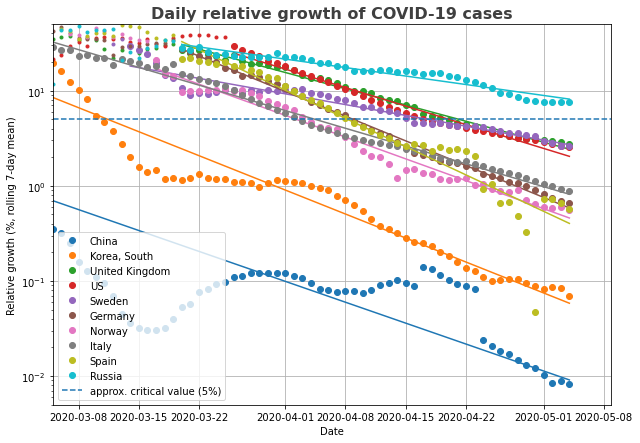

In [4]:
fig = plt.figure(figsize=(10,7))

span = 7
rel = relgr.rolling(span).mean()

for n, c in enumerate(selcnt):
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    t = rel.index.to_pydatetime()
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    x = arange(rel.index.size)
    fit = polyfit(x[mm], log(rel[c].values[mm]), 1)
    p = plt.semilogy(rel.index[m], 100*rel[c].values[m], '.')[0]
    plt.plot(rel.index[mm], 100*rel[c].values[mm], 'o', label=c, color=p.get_color())
    plt.plot(rel.index[mm], 100 * exp(polyval(fit, x[mm])), color=p.get_color())

plt.axhline(5, ls='--', label='approx. critical value (5%)')
plt.ylim(None,50)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title('Daily relative growth of COVID-19 cases', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Relative growth (%, rolling {span}-day mean)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.savefig('relative_growth.png');

## Trajectory 
This one is inspired by the excellent https://aatishb.com/covidtrends/ page

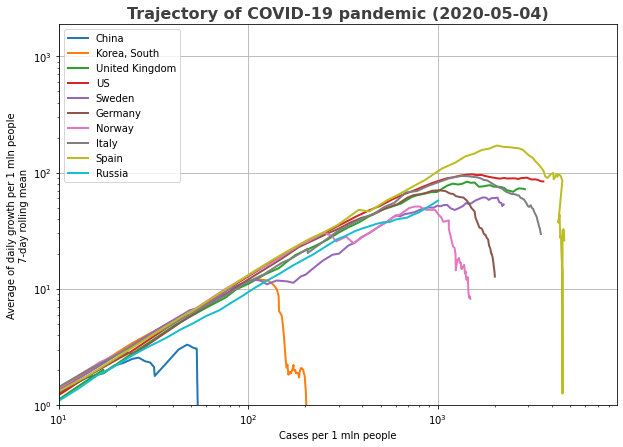

In [5]:
plt.figure(figsize=(10,7))
span = 7
val = confpc
gr = val.diff().rolling(span).mean()
for n, c in enumerate(selcnt):
    m = ~ gr[c].isnull()
    plt.loglog(val[c][m].values, gr[c][m].values, '-', label=c, lw=2)

plt.xlim(10,None)
plt.ylim(1,None)
plt.title(f'Trajectory of COVID-19 pandemic ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Average of daily growth per 1 mln people\n'+
           f'{span}-day rolling mean')
plt.xlabel('Cases per 1 mln people')
plt.legend()
plt.grid()
plt.savefig('trajectory.png');

## Other curves

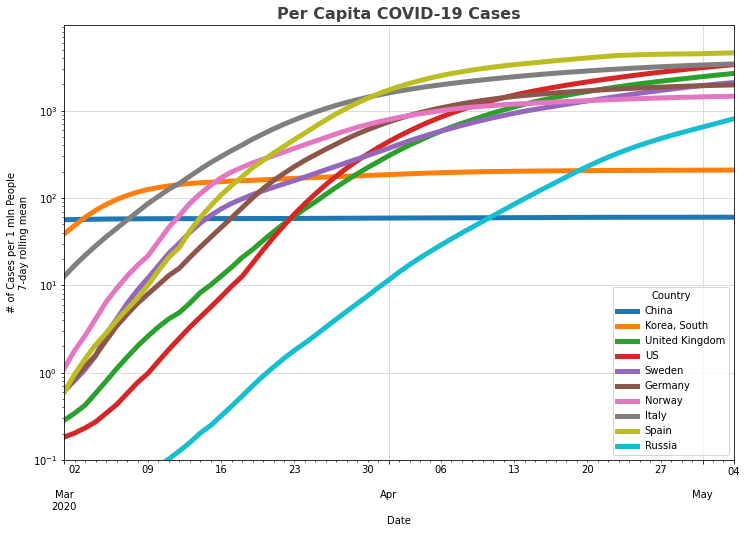

In [6]:
percapitaplot = confpc.rolling(span).mean()[selcnt].plot(figsize=(12,8), linewidth=5, logy=LOGY)
percapitaplot.grid(color='#d4d4d4')
percapitaplot.set_xlabel('Date')
percapitaplot.set_ylabel('# of Cases per 1 mln People\n'+
                         f'{span}-day rolling mean')
percapitaplot.set_xlim(pd.Timestamp('2020-03-1'),None)
percapitaplot.set_ylim(1e-1, None)
percapitaplot.set_title("Per Capita COVID-19 Cases", 
                        fontsize = 16, weight = 'bold', alpha = .75);

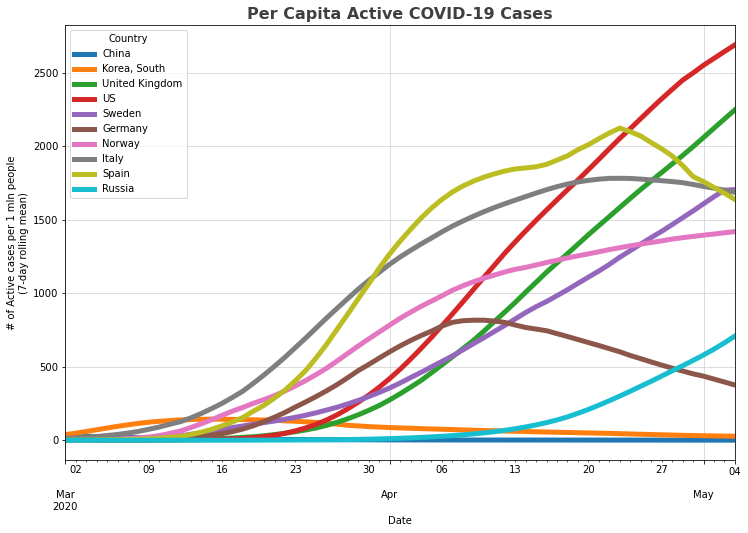

In [7]:
percapitaplot = (confpc - recovpc - victpc).rolling(span).mean()[selcnt].plot(figsize=(12,8), linewidth=5)
percapitaplot.grid(color='#d4d4d4')
percapitaplot.set_xlabel('Date')
percapitaplot.set_ylabel(f'# of Active cases per 1 mln people\n'+
                         f'({span}-day rolling mean)')
percapitaplot.set_xlim(pd.Timestamp('2020-03-1'),None)
percapitaplot.set_title("Per Capita Active COVID-19 Cases", 
                        fontsize = 16, weight = 'bold', alpha = .75);

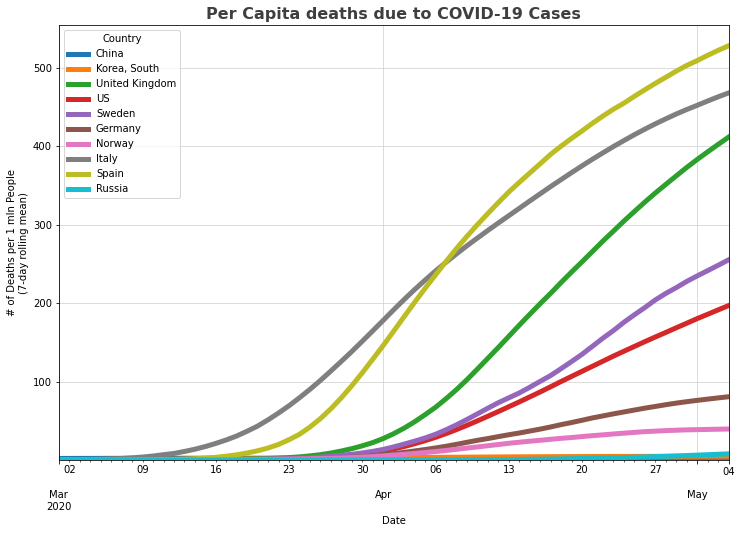

In [8]:
vplot = victpc.rolling(span).mean()[selcnt].plot(figsize=(12,8), linewidth=5, logy=False)
vplot.grid(color='#d4d4d4')
vplot.set_xlabel('Date')
vplot.set_ylabel('# of Deaths per 1 mln People\n'+
                 f'({span}-day rolling mean)')
vplot.set_xlim(pd.Timestamp('2020-03-1'),None)
vplot.set_ylim(1e-2, None)
vplot.set_title("Per Capita deaths due to COVID-19 Cases", fontsize = 16, weight = 'bold', alpha = .75);

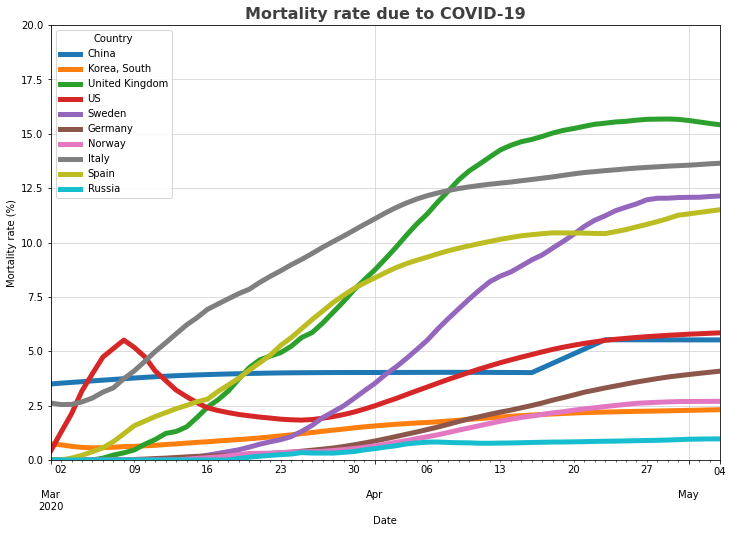

In [9]:
mortplt = (100*vict/conf).rolling(span).mean()[selcnt].plot(figsize=(12,8), linewidth=5, logy=False)
mortplt.grid(color='#d4d4d4')
mortplt.set_xlim(pd.Timestamp('2020-03-1'),None)
mortplt.set_ylim(0, 20)
mortplt.set_xlabel('Date')
mortplt.set_ylabel('Mortality rate (%)')
mortplt.set_title('Mortality rate due to COVID-19', fontsize = 16, weight = 'bold', alpha = .75);

## Polish Wikipedia plots
These are plots created for Polish Wikipedia

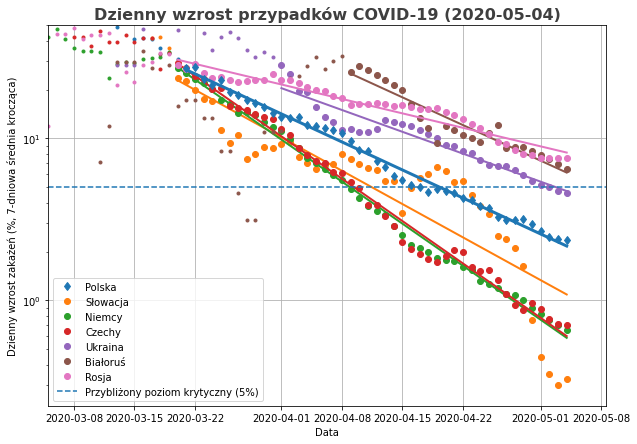

In [10]:
fig = plt.figure(figsize=(10,7))

def plleg(c):
    pl = {
        'Poland':'Polska', 
        'Slovakia': 'Słowacja', 
        'Germany': 'Niemcy',
        'Czechia': 'Czechy',
        'Ukraine': 'Ukraina', 
        'Belarus': 'Białoruś', 
        'Russia': 'Rosja'
    }
    if c in pl:
        return pl[c]
    else :
        return c

span = 7
rel = relgr.rolling(span).mean()

model = {}

for n, c in enumerate(plwiki):
    m = ~ (np.isnan(rel[c].values) | np.isinf(rel[c].values))
    t = np.arange(m.size)
    t = rel.index.to_pydatetime()
    for s, v in zip(t[m][::-1], rel[c].values[m][::-1]):
        if v>0.3 :
            break
    mm = m & (t > s)
    x = arange(rel.index.size)
    fit = polyfit(x[mm], log(rel[c].values[mm]), 1)
    model[c] = fit, x[mm]
    p = plt.semilogy(rel.index[m], 100*rel[c].values[m], '.')[0]
    plt.plot(rel.index[mm], 100*rel[c].values[mm], 
             'd' if c=='Poland' else 'o', 
             color=p.get_color(), label=plleg(c),
             zorder = 3 if c=='Poland' else 2,
            )
    plt.plot(rel.index[mm], 100 * exp(polyval(fit, x[mm])),
             color=p.get_color(),
             lw=3 if c=='Poland' else 2,
             zorder = 3 if c=='Poland' else 2)

plt.axhline(5, ls='--', label='Przybliżony poziom krytyczny (5%)')
plt.ylim(None,50)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title(f'Dzienny wzrost przypadków COVID-19 ({str(rel.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Dzienny wzrost zakażeń (%, {span}-dniowa średnia krocząca)')
plt.xlabel('Data')
plt.grid()
plt.legend(loc='lower left')
plt.savefig('wzrosty_dzienne.png');

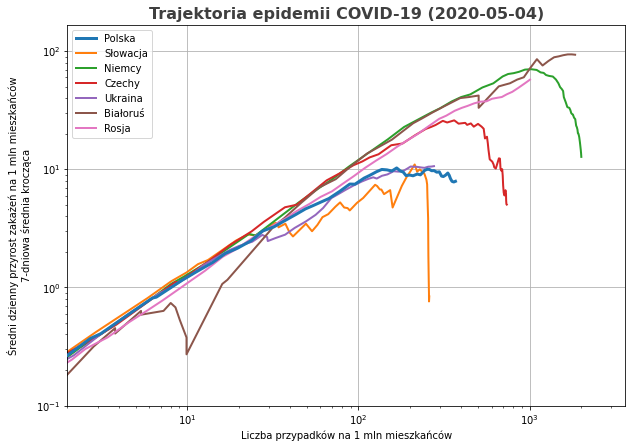

In [11]:
plt.figure(figsize=(10,7))
val = confpc
span = 7
gr = val.diff().rolling(span).mean()

for n, c in enumerate(plwiki):
    m = ~ gr[c].isnull()
    p = plt.loglog(val[c][m].values, gr[c][m].values, 
               '-', lw=3 if c=='Poland' else 2, label=plleg(c),
               zorder = 3 if c=='Poland' else 2)
    (b, a), t = model[c]
    c0 = val[c][-1]/exp(exp(b*t.max()+a)/b)
    ci = gr[c][m].values[-1]/(exp(exp(b*t.max()+a)/b)*exp(b*t.max()+a))
    t = linspace(t.min(), t.max()+60, 100)    
    #plt.loglog(exp(exp(b*t+a)/b)*c0,exp(exp(b*t+a)/b)*exp(b*t+a)*ci, ls=':', color=p[0].get_color())

plt.xlim(2,None)
plt.ylim(0.1,None)
plt.title(f'Trajektoria epidemii COVID-19 ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel('Średni dzienny przyrost zakażeń na 1 mln mieszkańców\n'+
           f'{span}-dniowa średnia krocząca')
plt.xlabel('Liczba przypadków na 1 mln mieszkańców')
plt.legend(loc='upper left')
plt.grid()
plt.savefig('trajektoria_covid.png');

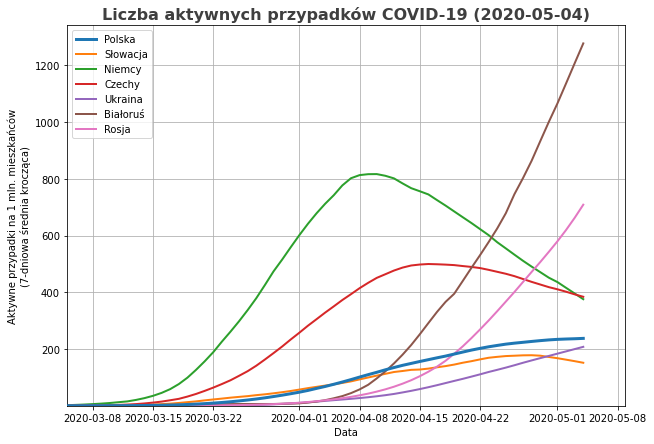

In [12]:
plt.figure(figsize=(10,7))
val = (confpc - recovpc - victpc)
span = 7
val = val.rolling(span).mean()

for n, c in enumerate(plwiki):
    m = ~ (np.isnan(val[c].values) | np.isinf(val[c].values))
    plt.plot(val.index[m], val[c].values[m], '-',
             lw=3 if c=='Poland' else 2, label=plleg(c),
               zorder = 3 if c=='Poland' else 2
            )

plt.ylim(1e-2,None)
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title(f'Liczba aktywnych przypadków COVID-19 ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Aktywne przypadki na 1 mln. mieszkańców\n({span}-dniowa średnia krocząca)')
plt.xlabel('Data')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('aktywne_przypadki.png');

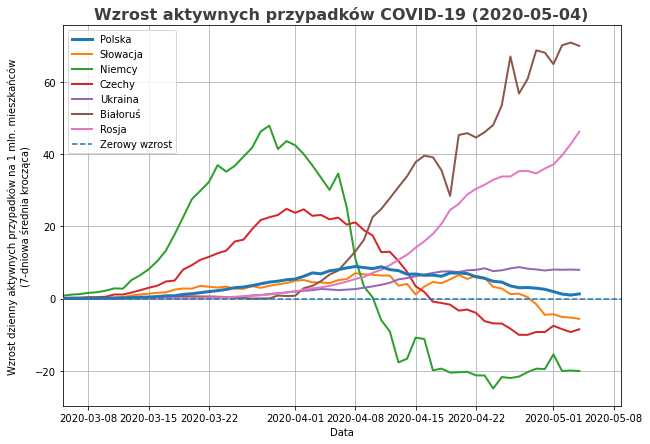

In [13]:
plt.figure(figsize=(10,7))
val = (confpc - recovpc - victpc)
span = 7
val = val.diff().rolling(span).mean()

for n, c in enumerate(plwiki):
    m = ~ (np.isnan(val[c].values) | np.isinf(val[c].values))
    plt.plot(val.index[m], val[c].values[m], '-',
             lw=3 if c=='Poland' else 2, label=plleg(c),
               zorder = 3 if c=='Poland' else 2
            )

plt.ylim(None,None)
plt.axhline(ls='--', label='Zerowy wzrost')
plt.xlim(pd.Timestamp('2020-03-5'),None)
plt.title(f'Wzrost aktywnych przypadków COVID-19 ({str(val.index[-1]).split()[0]})', fontsize = 16, weight = 'bold', alpha = .75)
plt.ylabel(f'Wzrost dzienny aktywnych przypadków na 1 mln. mieszkańców\n({span}-dniowa średnia krocząca)')
plt.xlabel('Data')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('aktywne_wzrost.png');

## Experiments

Here are some experiments with modelling based on the remarkable good fit
of the relative daily growth curves. This is not very much work in progress.
And as everything here - this is just my experiments to calm my mind.

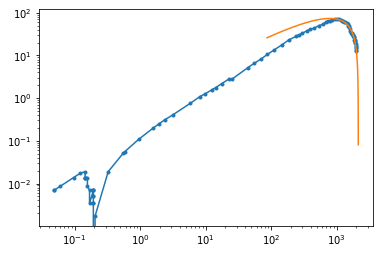

In [14]:
c = 'Germany'
m = ~ gr[c].isnull()
plot(confpc[c][m].values, gr[c][m].values,'.-')    
(b, a), t = model[c]
c0 = confpc[c][-1]/exp(exp(b*t.max()+a)/b)
ci = gr[c][m].values[-1]/(exp(exp(b*t.max()+a)/b)*exp(b*t.max()+a))
t = linspace(t.min(), t.max()+60, 100)    
loglog(exp(exp(b*t+a)/b)*c0,exp(exp(b*t+a)/b)*exp(b*t+a)*ci, '-');

In [15]:
model

{'Poland': (array([-0.0569648 ,  2.03340795]),
  array([ 59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
          85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103])),
 'Slovakia': (array([-0.06771232,  2.45105376]),
  array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
          71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
          97,  98,  99, 100, 101, 102, 103])),
 'Germany': (array([-0.08547251,  3.66332722]),
  array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
          71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
          97,  98,  99, 100, 101, 102, 103])),
 'Czechia': (array([-0.08610944,  3.75424709]),
  arra

In [16]:
conf[-3:]

Country,Belarus,China,Czechia,Germany,Italy,"Korea, South",Norway,Poland,Russia,Slovakia,Spain,Sweden,US,Ukraine,United Kingdom
Date,,,,,,,,,,,,,,,
2020-05-02,15828,83959,7755,164967,209328,10793,7809,13375,124054,1407,216582,22082,1132539,11411,183500
2020-05-03,16705,83964,7781,165664,210717,10801,7847,13693,134687,1408,217466,22317,1158040,11913,187842
2020-05-04,17489,83966,7819,166152,211938,10804,7904,14006,145268,1413,218011,22721,1180375,12331,191832
